In [16]:
import h5py
import numpy as np

# Define a list of dataset filenames and corresponding labels
filenames = [
    ('D:/Project/pchem_data/camelyonpatch_level_2_split_train_x.h5', 'D:/Project/pchem_data/camelyonpatch_level_2_split_train_y.h5'),
    ('D:/Project/pchem_data/camelyonpatch_level_2_split_test_x.h5', 'D:/Project/pchem_data/camelyonpatch_level_2_split_test_y.h5'),
    ('D:/Project/pchem_data/camelyonpatch_level_2_split_valid_x.h5', 'D:/Project/pchem_data/camelyonpatch_level_2_split_valid_y.h5')
]

# Define the subset size
subset_size = 1000

# Iterate over the dataset pairs
for x_filename, y_filename in filenames:
    # Load the x and y datasets from the H5 file separately
    with h5py.File(x_filename, 'r') as h5_file:
        x = h5_file['x'][:]
        
    with h5py.File(y_filename, 'r') as h5_file:
        y = h5_file['y'][:]
        
    # Create a subset of the data consisting of the first `subset_size` images
    x_subset = x[:subset_size]
    y_subset = y[:subset_size]

    # Save the subset to a new H5 file
    subset_filename = x_filename.replace('.h5', '_subset.h5')
    with h5py.File(subset_filename, 'w') as h5_file:
        h5_file.create_dataset('x', data=x_subset)
        h5_file.create_dataset('y', data=y_subset)
        
    # Use the subset for any further analysis
    # For example, print the shape of the subset
    print(x_subset.shape)  # Output: (1000, height, width, channels)
    print(y_subset.shape)  # Output: (1000, )
    print(np.unique(y_subset))  # Output: [0 1]


(1000, 96, 96, 3)
(1000, 1, 1, 1)
[0 1]
(1000, 96, 96, 3)
(1000, 1, 1, 1)
[0 1]
(1000, 96, 96, 3)
(1000, 1, 1, 1)
[0 1]


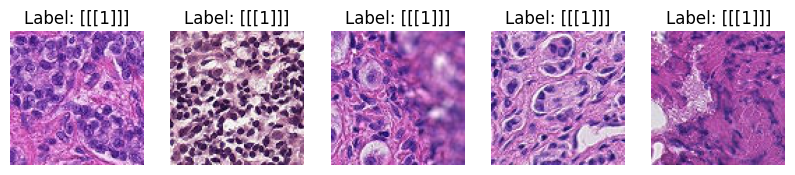

In [17]:
import matplotlib.pyplot as plt

# Plot first 5 images with their labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))

for i in range(5):
    axes[i].imshow(train_x_subset[i])
    axes[i].set_title('Label: {}'.format(train_y_subset[i]))
    axes[i].axis('off')

plt.show()


In [18]:
import torch
from torchvision import transforms

# Define the transforms to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply the transforms to the subset of the data
train_x_transformed = torch.stack([transform(train_x_subset[i]) for i in range(len(train_x_subset))])
train_y_transformed = torch.Tensor(train_y_subset)

# Print the shape of the transformed data
print(train_x_transformed.shape)  # Output: torch.Size([1000, 3, height, width])
print(train_y_transformed.shape)  # Output: torch.Size([1000])
print(train_y_transformed[0])  # Output: tensor(0.)


torch.Size([1000, 3, 96, 96])
torch.Size([1000, 1, 1, 1])
tensor([[[1.]]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


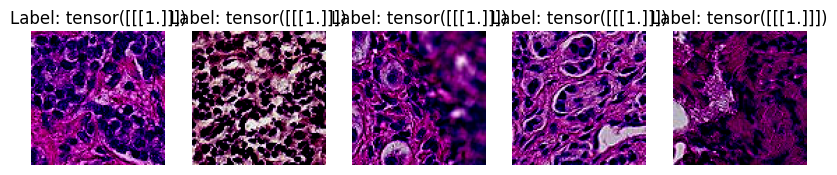

In [19]:
import matplotlib.pyplot as plt

# Plot first 5 transformed images with their labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))

for i in range(5):
    axes[i].imshow(train_x_transformed[i].permute(1, 2, 0))
    axes[i].set_title('Label: {}'.format(train_y_transformed[i]))
    axes[i].axis('off')

plt.show()


In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Set the seed for reproducibility
torch.manual_seed(42)

# Define the indices for train, test, and validation sets
num_samples = len(train_x_transformed)
indices = list(range(num_samples))
split1 = int(0.8*num_samples)
split2 = int(0.9*num_samples)

train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]

# Create TensorDatasets for train, test, and validation sets
train_dataset = TensorDataset(train_x_transformed[train_indices], train_y_transformed[train_indices])
val_dataset = TensorDataset(train_x_transformed[val_indices], train_y_transformed[val_indices])
test_dataset = TensorDataset(train_x_transformed[test_indices], train_y_transformed[test_indices])

# Create DataLoaders for train, test, and validation sets
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)



Epoch [1], Loss: 0.4819, Validation Accuracy: 75.00%
Epoch [2], Loss: 0.3489, Validation Accuracy: 87.00%
Epoch [3], Loss: 0.4142, Validation Accuracy: 83.00%
Epoch [4], Loss: 0.3238, Validation Accuracy: 87.00%
Epoch [5], Loss: 0.2926, Validation Accuracy: 88.00%
Epoch [6], Loss: 0.3190, Validation Accuracy: 86.00%
Epoch [7], Loss: 0.3213, Validation Accuracy: 88.00%
Epoch [8], Loss: 0.3072, Validation Accuracy: 89.00%
Epoch [9], Loss: 0.3655, Validation Accuracy: 87.00%
Epoch [10], Loss: 0.3841, Validation Accuracy: 87.00%


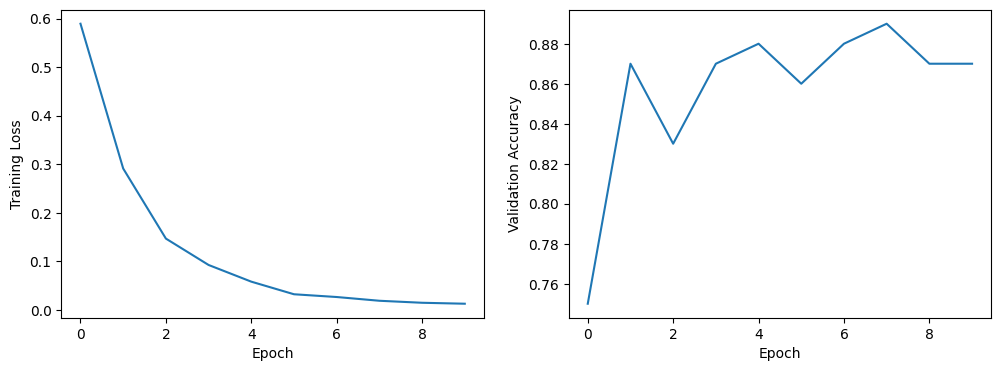

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

# Load a pretrained ResNet18 model
resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

# Define the number of epochs
num_epochs = 10

# Store the training loss and validation accuracy for each epoch
train_loss_values = []
val_accuracy_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    resnet18.train()  # Set the model to training mode

    # Train the model using the train data loader
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        labels = labels.squeeze(1).squeeze(1).squeeze(1).long()  # Convert to long type and remove extra dimensions from labels
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

    train_loss_values.append(epoch_loss)

    resnet18.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    # Evaluate the model using the validation data loader
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = resnet18(inputs)
            labels = labels.squeeze(1).squeeze(1).squeeze(1).long()  # Convert to long type and remove extra dimensions from labels
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(val_dataloader.dataset)

    val_accuracy_values.append(epoch_acc)
    
    # Print epoch statistics
    print('Epoch [%d], Loss: %.4f, Validation Accuracy: %.2f%%' %
          (epoch + 1, epoch_loss, epoch_acc*100))

# Plot the training loss vs epoch and validation accuracy vs epoch
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(range(num_epochs), train_loss_values)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Loss')

ax[1].plot(range(num_epochs), val_accuracy_values)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation Accuracy')

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

# define the device to use for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the model to evaluation mode
model.eval()

# Initialize variables to store total and correct predictions
total = 0
correct = 0

# Disable gradient computation to speed up inference
with torch.no_grad():

    # Iterate over the test dataloader
    for data in test_dataloader:

        # Get inputs and labels from the dataloader
        inputs, labels = data

        # Move inputs and labels to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Make predictions
        outputs = model(inputs)

        # Get the index of the class with the highest probability
        _, predicted = torch.max(outputs.data, 1)

        # Add the number of samples to the total count
        total += labels.size(0)

        # Add the number of correct predictions to the correct count
        correct += (predicted == labels).sum().item()

# Compute the accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

# Define the device to use for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pretrained ResNet18 model
resnet18 = resnet18(pretrained=True)

# Modify the last layer to fit your binary classification task
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
resnet18.to(device)

# Set the model to evaluation mode
resnet18.eval()

# Initialize variables to store total and correct predictions
total = 0
correct = 0

# Disable gradient computation to speed up inference
with torch.no_grad():

    # Iterate over the test dataloader
    for data in test_dataloader:

        # Get inputs and labels from the dataloader
        inputs, labels = data

        # Move inputs and labels to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Make predictions
        outputs = resnet18(inputs)

        # Get the index of the class with the highest probability
        _, predicted = torch.max(outputs.data, 1)

        # Add the number of samples to the total count
        total += labels.size(0)

        # Add the number of correct predictions to the correct count
        correct += (predicted == labels).sum().item()

# Compute the accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
